## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
import datetime as dt

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

from variables import day_of_week_translator, feriados, vesperas

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [105]:
# Reading Data file (geolocalized)
data = pd.read_csv('../data_input_zerofill_2015.csv', delimiter=";")

data['data_hora'] = pd.to_datetime(data['data_hora'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
data_model = data.loc[data.data_hora.dt.year == 2015].copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

busline_filter = 41

In [106]:
data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
0,1,2015-01-15 02:00:00,0,3,0.519584,0.854419,2,15,15,1,3
1,1,2015-01-25 02:00:00,0,6,0.519584,0.854419,2,25,25,1,4
2,1,2015-01-25 06:00:00,0,6,0.997669,-0.068242,6,25,25,1,4
3,1,2015-01-25 07:00:00,0,6,0.942261,-0.334880,7,25,25,1,4
4,1,2015-01-25 08:00:00,0,6,0.816970,-0.576680,8,25,25,1,4
...,...,...,...,...,...,...,...,...,...,...,...
2081985,999,2015-12-05 09:00:00,18,5,0.631088,-0.775711,9,5,339,12,0
2081986,999,2015-12-05 10:00:00,64,5,0.398401,-0.917211,10,5,339,12,0
2081987,999,2015-12-05 11:00:00,8,5,0.136167,-0.990686,11,5,339,12,0
2081988,999,2015-12-05 12:00:00,43,5,-0.136167,-0.990686,12,5,339,12,0


In [107]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.groupby(data_model.linha).sum().reset_index().sort_values('validations_per_hour', ascending=False).index[:100].to_list()
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)]

top100_linhas_data_model.to_csv("../dados-para-modelos/2015/top100_linhas_data_model_2015.csv", index=False)
line_data_model = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == busline_filter].copy()

#sns.set(rc={'figure.figsize':(15,10)})
# sns.heatmap(top100_linhas_data_model.corr()[['validations_per_hour']].sort_values(by='validations_per_hour', ascending=False)
# , vmin=-1, vmax=1, annot=True)

In [108]:
top100_linhas_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
0,1,2015-01-15 02:00:00,0,3,5.195840e-01,0.854419,2,15,15,1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
1,1,2015-01-25 02:00:00,0,6,5.195840e-01,0.854419,2,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
2,1,2015-01-25 06:00:00,0,6,9.976688e-01,-0.068242,6,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,1,2015-01-25 07:00:00,0,6,9.422609e-01,-0.334880,7,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,1,2015-01-25 08:00:00,0,6,8.169699e-01,-0.576680,8,25,25,1,4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091838,355,2015-12-31 19:00:00,161,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1091839,355,2015-12-31 20:00:00,189,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1091840,355,2015-12-31 21:00:00,163,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
1091841,355,2015-12-31 22:00:00,47,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


In [109]:
#display(X)

In [110]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [111]:
# Per Line Data

X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [112]:
model_list = []

In [113]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    mape = mean_absolute_percentage_error(Y_test, y_test_predict) * 100
    performance_scoring = [
        r2,
        rmse,
        mae,
        mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

In [114]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [115]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [116]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

# Grid Searched

In [117]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearched_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)

GridSearchedRandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)
DefaultRandomForestModelPipeline = make_pipeline(default_randomforest_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 673,
 'n_jobs': 6}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 2, 'normalize': True}


In [118]:
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)
performance_gridsearched_linearregression_model = get_performance(gridsearched_random_linearregression)
performance_default_linearregression_model = get_performance(default_linearregression_model)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE', 'MAPE'], 
    index=['Regressao Linear Default', 'RandomForest Default', 'Regressao Linear Grid Searched', 'RandomForest GridSearched'])
performance_total


----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.4754712646752065, 319.5637789560184, 247.9261653133081, 1.3515391393865427e+19]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.9193882276129877, 125.27722954939736, 69.3838799775659, 3.938469954221675e+18]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.475659326711662, 319.50648638197794, 247.81043185642176, 1.3480488621018698e+19]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.936051929591855, 111.58006956497965, 71.44648801294362, 3.738952593991635e+18]

----------------------------------------------------



,R2,RMSE,MAE,MAPE
Regressao Linear Default,0.475471,319.563779,247.926165,1.351539e+19
RandomForest Default,0.919388,125.277230,69.383880,3.938470e+18
Regressao Linear Grid Searched,0.475659,319.506486,247.810432,1.348049e+19
RandomForest GridSearched,0.936052,111.580070,71.446488,3.738953e+18


# BAGGING

In [119]:
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(gridsearched_random_linearregression)
RandomForestModelPipeline = make_pipeline(gridsearched_random_randomforest)

bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Regressao Linear Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])

BaggingLinearRegressionModelPipeline = make_pipeline(bagging_lr_model)
BaggingRandomForestModelPipeline = make_pipeline(bagging_rf_model)


Performance for base estimator Pipeline(steps=[('linearregression',
                 LinearRegression(n_jobs=2, normalize=True))]) = [0.4756920484282684, 319.4965167531201, 248.0740263690806, 1.3425030324911176e+19]

Performance for base estimator Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_depth=60,
                                       max_features='sqrt', min_samples_split=5,
                                       n_estimators=673, n_jobs=6))]) = [0.9334331446001751, 113.84184519371702, 73.38389668186498, 4.3813701458706186e+18]



# BOOSTING

In [120]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['GradientBoostingRegressor'])

GradientBoostingModelPipeline = make_pipeline(gradient_boosting_regressor)

performance_total = pd.concat([df2, performance_total])


# STACKING

In [121]:
estimators = [
    ('gridseached_randomforest', GridSearchedRandomForestModelPipeline),
    ('bagging_randomforest',BaggingRandomForestModelPipeline),
    ('gradient_boosting', GradientBoostingModelPipeline), 
    ('random_forest_default', DefaultRandomForestModelPipeline)
]

stack = StackingRegressor(estimators=estimators, final_estimator=DefaultRandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE', 'MAPE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])

In [122]:
# model_list = [
#     stack,
#     gradient_boosting_regressor,
#     bagging_rf_model,
#     default_randomforest_model,
#     #default_linearregression_model,
#     #gridsearched_result_linearregression,
#     #gridsearched_random_randomforest,
#     #bagging_lr_model,
# ]

sample = X.sample(n=1)
sample

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

display(data_model.loc[sample.index])

res = stack.predict(sample)
print("Stacked Regressor -> resultado do predict de test: ", res)

res = gradient_boosting_regressor.predict(sample)
print("gradient_boosting_regressor -> resultado do predict de test: ", res)

res = bagging_rf_model.predict(sample)
print("bagging_rf_model -> resultado do predict de test: ", res)

res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", res)

res = default_randomforest_model.predict(sample)
print("Random Forest Default -> resultado do predict de test: ", res)

res = bagging_lr_model.predict(sample)
print("bagging_lr_model -> resultado do predict de test: ", res)

res = default_linearregression_model.predict(sample)
print("Regressao Linear Default -> resultado do predict de test: ", res)

res = gridsearched_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", res)

LINHA UTILIZADA PARA OS TESTES:  41

Utilizando sample aleatorio de dado para teste de previsao: 


,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
237601,41,2015-10-12 16:00:00,597,0,-0.942261,-0.33488,16,12,285,10,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


Stacked Regressor -> resultado do predict de test:  [770.49]
gradient_boosting_regressor -> resultado do predict de test:  [724.93201198]
bagging_rf_model -> resultado do predict de test:  [748.85794948]
Random Forest Best Grid Searched -> resultado do predict de test:  [669.7526003]
Random Forest Default -> resultado do predict de test:  [804.14]
bagging_lr_model -> resultado do predict de test:  [699.08814631]
Regressao Linear Default -> resultado do predict de test:  [688.25181447]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [690.]


In [123]:
performance_total = performance_total.sort_values('MAE', ascending=True)
performance_total.to_csv('../performances/2015/performance_total_linha'+str(busline_filter)+'.csv', index=False)

In [124]:
performance_total

,R2,RMSE,MAE,MAPE
Stacking Regressors,0.970403,75.909348,48.037192,1.022825e+18
GradientBoostingRegressor,0.956385,92.149368,58.983640,3.823324e+18
RandomForest Default,0.919388,125.277230,69.383880,3.938470e+18
RandomForest GridSearched,0.936052,111.580070,71.446488,3.738953e+18
RandomForest Bagging,0.933433,113.841845,73.383897,4.381370e+18
Regressao Linear Grid Searched,0.475659,319.506486,247.810432,1.348049e+19
Regressao Linear Default,0.475471,319.563779,247.926165,1.351539e+19
Regressao Linear Bagging,0.475692,319.496517,248.074026,1.342503e+19


### Todos os modelos treinados dentro de *model_list*

In [125]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    gridsearch_result_randomforest
]

In [134]:
line_data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
230377,41,2015-01-02 01:00:00,0,4,2.697968e-01,0.962917,1,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230378,41,2015-01-02 02:00:00,0,4,5.195840e-01,0.854419,2,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230379,41,2015-01-02 03:00:00,0,4,7.308360e-01,0.682553,3,2,2,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
230380,41,2015-01-03 01:00:00,0,5,2.697968e-01,0.962917,1,3,3,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
230381,41,2015-01-03 02:00:00,0,5,5.195840e-01,0.854419,2,3,3,1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239285,41,2015-12-31 19:00:00,574,3,-8.878852e-01,0.460065,19,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239286,41,2015-12-31 20:00:00,432,3,-7.308360e-01,0.682553,20,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239287,41,2015-12-31 21:00:00,331,3,-5.195840e-01,0.854419,21,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1
239288,41,2015-12-31 22:00:00,178,3,-2.697968e-01,0.962917,22,31,365,12,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1


## Treinar com 1 mes, prever N semanas

In [129]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

meses_de_treino = [1,3]
mes_de_previsao = 4

line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  8].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[],[]]
performances = list()

for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [132]:
df_performance = pd.DataFrame(performances)
df_performance.to_csv('../performances/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_performance.csv', index=False)
df_predict_dados = real_values
df_predict_dados['validations_per_hour_predicted'] = predictions[0]

df_predict_dados.to_csv('../predict-vs-real/2015/linha'+str(busline_filter)+'_'+str(meses_de_treino)+'meses_1semana('+str(mes_de_previsao)+')_predict.csv', index=False)

df_performance

,0,1,2,3
0,0.971452,72.389382,46.129348,3.724776e+17
1,0.970803,73.208657,51.343124,2.247016e+18
2,0.940371,104.620860,78.678906,3.002213e+18
3,0.963963,81.332851,53.332468,1.407834e+18
4,0.966141,78.836256,52.182707,1.211735e+18


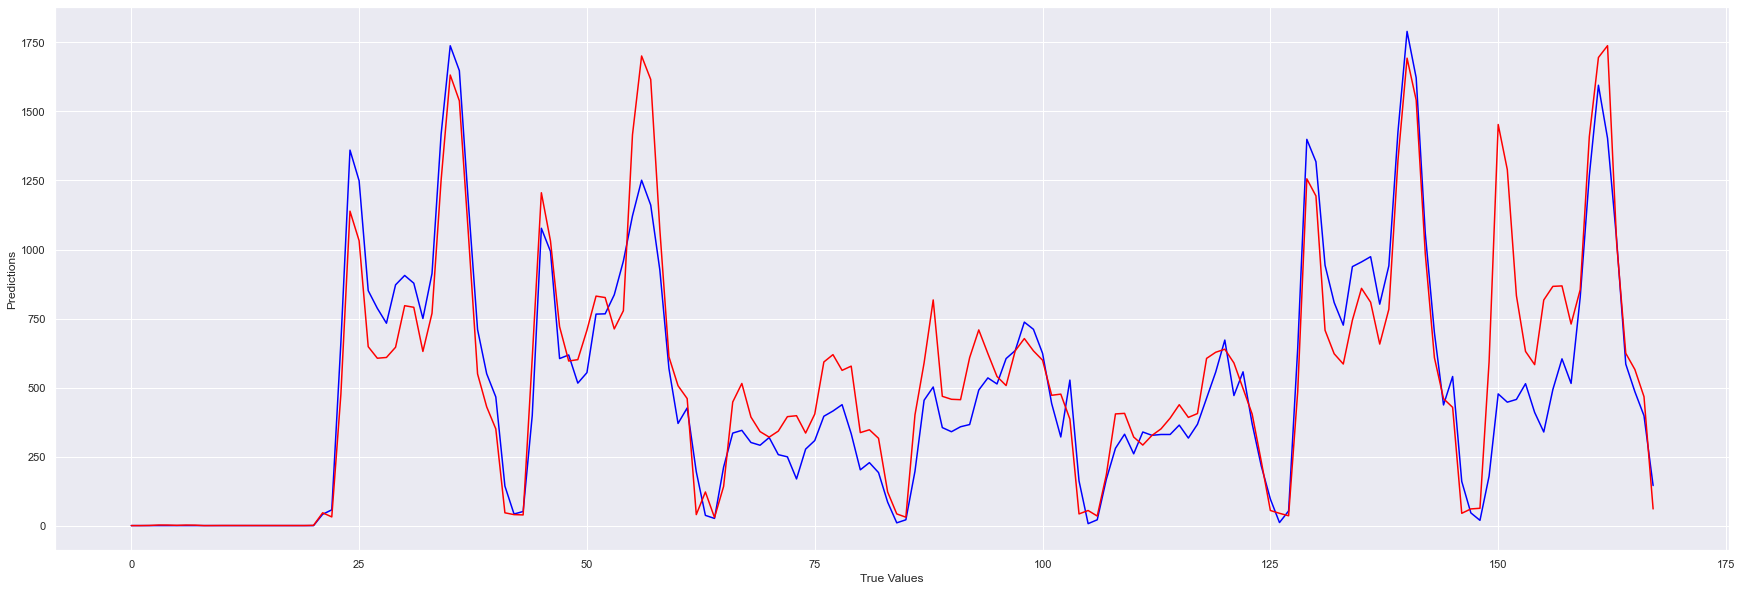

In [133]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168

plt.figure(figsize=(30, 10))
plt.plot(range(df_predict_dados.validations_per_hour.size), df_predict_dados.validations_per_hour.values, color='blue')
plt.plot(range(predictions[0].__len__()), predictions[0], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [136]:
line_data_model.loc[line_data_model.mes == 4].loc[line_data_model.d_mes < 8]

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
230684,41,2015-04-01 01:00:00,0,2,2.697968e-01,0.962917,1,1,91,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
230685,41,2015-04-01 02:00:00,0,2,5.195840e-01,0.854419,2,1,91,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
230686,41,2015-04-01 03:00:00,0,2,7.308360e-01,0.682553,3,1,91,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0
230687,41,2015-04-02 01:00:00,0,3,2.697968e-01,0.962917,1,2,92,4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
230688,41,2015-04-02 02:00:00,0,3,5.195840e-01,0.854419,2,2,92,4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233664,41,2015-04-07 19:00:00,1034,1,-8.878852e-01,0.460065,19,7,97,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
233665,41,2015-04-07 20:00:00,585,1,-7.308360e-01,0.682553,20,7,97,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
233666,41,2015-04-07 21:00:00,485,1,-5.195840e-01,0.854419,21,7,97,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0
233667,41,2015-04-07 22:00:00,398,1,-2.697968e-01,0.962917,22,7,97,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0


### Treinar com (N-Y) meses, Prever mes (N)

In [53]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

meses_de_treino = [1,2,3]
mes_de_previsao = 4
dias_de_previsao = 7

line_mes_data_model = line_data_model[line_data_model.mes.isin(meses_de_treino)]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.d_mes <  dias_de_previsao+1].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[],[]]
performances = list()

for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])


191


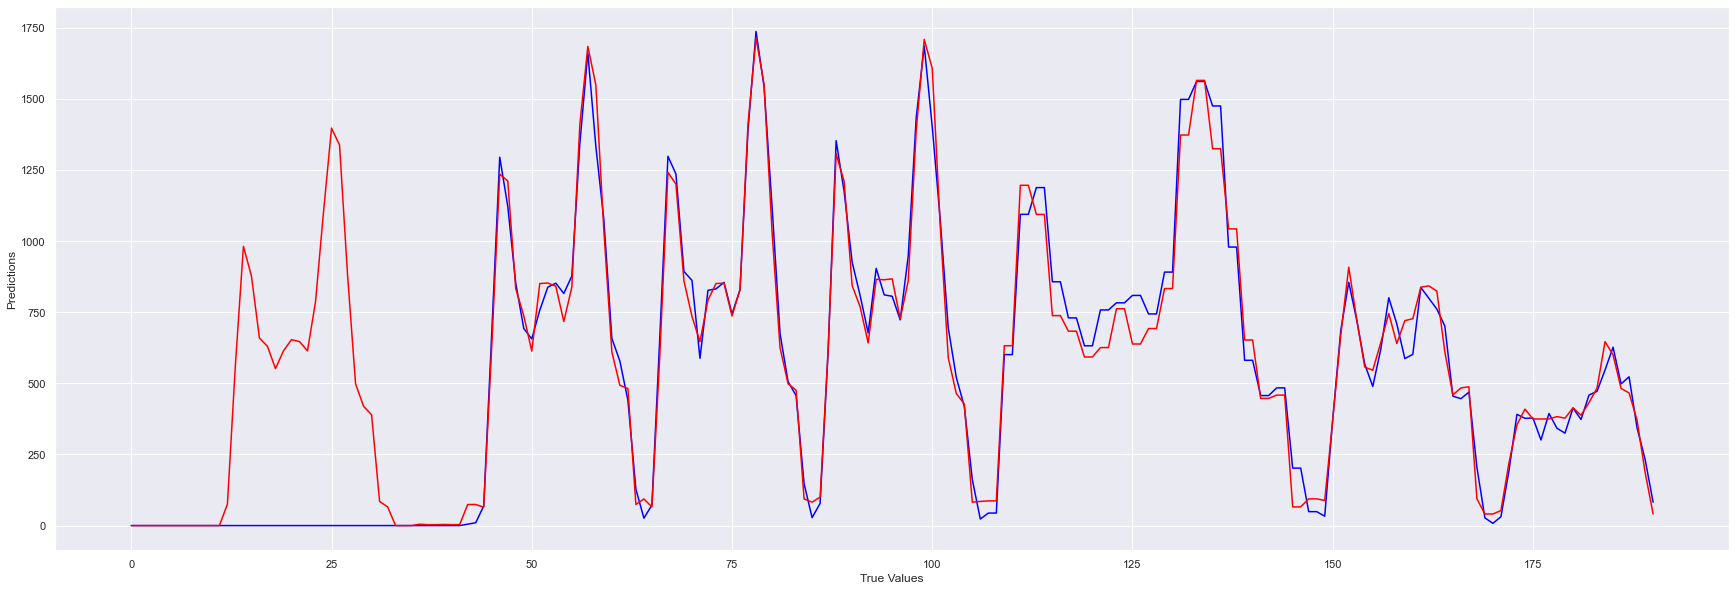

In [54]:
# 168 == quantidade de horas previstas em 1 semana
plt_size = 168

plt.figure(figsize=(30, 10))
plt.plot(range(df_results.size), df_results.values, color='blue')
plt.plot(range(predictions.__len__()), predictions, color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
performances

## Ranking Linhas de Onibus

In [29]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
res_map = list()
top100_linhas = data_model.linha.value_counts().index[:100]

for linha in top100_linhas:
    currentLinhaData = top100_linhas_data_model.loc[top100_linhas_data_model['linha'] == linha].copy()
    X = currentLinhaData.filter(feature_names, axis=1)
    y = currentLinhaData.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    for model in model_list:
        model.fit(X_train, Y_train)
        performance = get_performance(model)
        performance.insert(0, linha)
        res_map.append(performance)
res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE", 'MAPE'])
r = res_map.sort_values('MAE', ascending=True)
r.to_csv("../performances/2015/ranking_top100_2015.csv", index=False)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 3

In [ ]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE', 'MAPE'])

#performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
res_map = res_map.sort_values('MAE', ascending=True).reset_index(drop=True)
res_map = res_map.drop_duplicates(subset='Linha', keep="first").reset_index(drop=True)
res_map.to_csv('../top100linhas_rank_2015.csv', index=False)
res_map